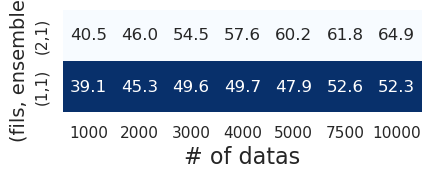

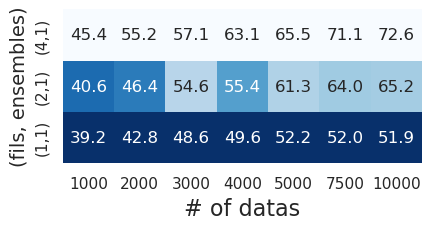

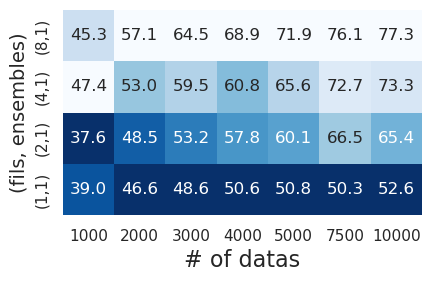

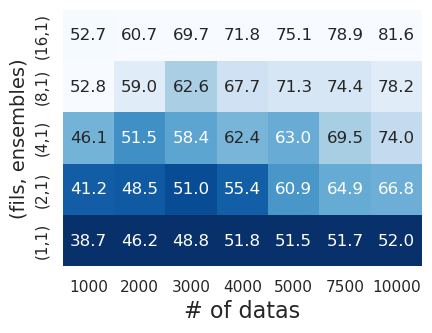

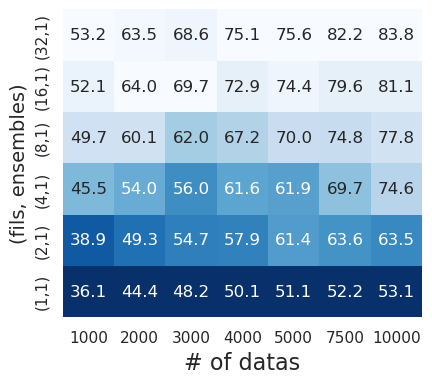

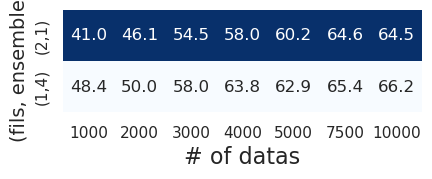

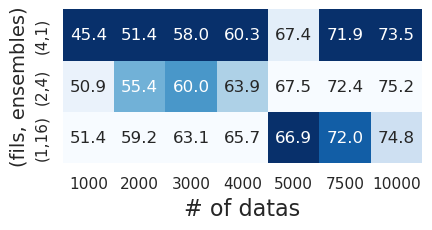

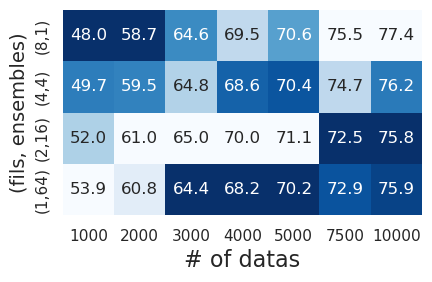

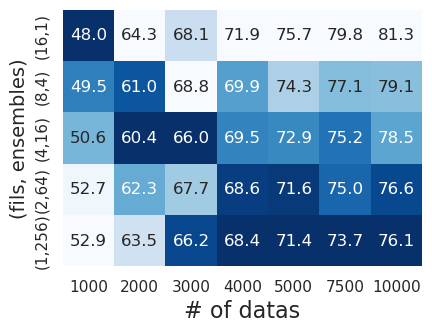

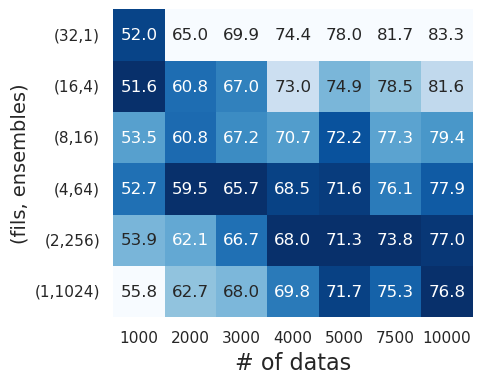

In [1]:
import polars as pl
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns

import sys
work_path = Path(next((p for p in Path("__file__").resolve().parents if p.name == "Research"), None))
torchlib_path = str(work_path / Path("app/torch_libs"))
sys.path.append(torchlib_path)

from run_manager import RunManager, RunsManager, RunViewer


exp_dirs = ["./exp_single_2", "./exp_single_4", "./exp_single_8", "./exp_single_16", "./exp_single_32"] 
# exp_dirs = ["./exp_4", "./exp_8", "./exp_16", "./exp_32", "./exp_64"] 
exp_dirs += ["./exp_udata_2", "./exp_udata_4", "./exp_udata_8", "./exp_udata_16", "./exp_udata_32"]

# '/home/haselab/Documents/tat/Research/app/ee2/runs'

for exp_dir in exp_dirs:
    rv = RunViewer(exp_path=exp_dir)
    # rv.write_stats()


    def heat_pivot(df, values, index, columns, aggregate_function=None, cmap=None, xlabels=None, ylabels=None, annot_rescale=False, color_rescale=False):
        df = df.sort(columns)
        df = df.pivot(values=values, index=index, columns=columns, aggregate_function=aggregate_function)
        df = df.reverse()
        # df = df.select(df.columns[::-1])
        df_ind_ser= df.select(index).to_series()
        df = df.select(pl.all().exclude(index))

        if xlabels is None:
            xlabels = df.columns
        if ylabels is None:
            ylabels = df_ind_ser
        
        
        # heatmap用
        def rescale(df):
            for col_name in df.columns:
                col_ser = df[col_name]
                max_val = col_ser.max()
                min_val = col_ser.min()
                
                if max_val != min_val:
                    df = df.with_columns(pl.col(col_name).sub(min_val).truediv(max_val - min_val))
            return df
        re_df = rescale(df)
        

        if annot_rescale:
            annot_C = re_df.to_numpy()
        else:
            annot_C = df.to_numpy()

        if color_rescale:
            color_C = re_df.to_numpy()
        else:
            color_C = df.to_numpy()
        
        annot_C *= 100



        sns.set_theme(rc={"figure.figsize": (len(xlabels)/1.5, len(ylabels)/1.5)})
        # sns.set(rc={"figure.figsize": (20, 20)})


        ax = sns.heatmap(color_C, annot=annot_C, cbar=False, square=True, cmap=cmap, xticklabels=xlabels, yticklabels=ylabels, fmt=".1f")
        # ax = sns.heatmap(color_C, annot=annot_C, cbar=False, square=True, cmap=cmap, xticklabels=xlabels, yticklabels=ylabels)
        ax.set_xlabel("# of datas", fontsize=16)
        # ax.set_ylabel("fils", fontsize=16)
        ax.set_ylabel("(fils, ensembles)", fontsize=14, rotation=90)
        plt.show()


    df_stats = rv.fetch_stats()
    df_stats_ext = df_stats

# df_stats_ext = df_stats_ext.filter(pl.col("fils").is_in([2, 4, 8, 16, 32, 64]))
# df_stats_ext = df_stats_ext.filter(pl.col("num_data") >= 125)

    df_stats_ext = df_stats_ext.with_columns(pl.concat_str([pl.lit("("), pl.col("fils"), pl.lit(","), pl.col("ensembles"), pl.lit(")")]).alias("fe"))

    df_stats_ext = df_stats_ext.sort("fils")
# t = df_stats_ext["fe"].unique()

# a = df_stats_ext["fils"].unique().sort(descending=True)
# b = df_stats_ext["ensembles"].unique().sort()
# t = [(a, b) for a, b in zip(a, b)]

# df_stats = df_stats.with_columns((pl.col("fils").cast(pl.Utf8) + pl.lit(", ") + pl.col("ensembles").cast(pl.Utf8)).alias("fils_ensembles"))
# heat_pivot(df_stats_ext, values="val_acc", index="fe", columns="num_data", cmap="Blues_r", aggregate_function="mean", annot_rescale=False, color_rescale=True)

    df_stats_ext = df_stats_ext.with_columns((pl.col("train_acc") - pl.col("val_acc")).alias("train_val_diff"))

    heat_pivot(df_stats_ext, values="val_acc", index="fe", columns="num_data", cmap="Blues_r", aggregate_function="mean", annot_rescale=False, color_rescale=True)
    # heat_pivot(df_stats_ext, values="train_val_diff", index="fe", columns="num_data", cmap="Blues_r", aggregate_function="mean", annot_rescale=False, color_rescale=False)
    # heat_pivot(df_stats_ext, values="train_acc", index="fe", columns="num_data", cmap="Blues_r", aggregate_function="mean", annot_rescale=False, color_rescale=False)




In [2]:
def rv_to_figs(rv, place_row_col, place_col_col, graph_x_col, graph_y_col, label_col, window_size=None):
    df_stats = rv.fetch_stats().cast({"run_id": pl.Int32})
    df_mets = rv.fetch_metrics()

    df_mets = df_mets.join(df_stats, on="run_id", how="left").sort(by=place_row_col).sort(by=place_col_col)

    row_vals = df_stats[place_row_col].unique().reverse()
    col_vals = df_stats[place_col_col].unique()

    fig, ax = plt.subplots(nrows=len(row_vals), ncols=len(col_vals), squeeze=False)
    plt.subplots_adjust(hspace=0.35)
    fig.set_figwidth(6 * len(col_vals))
    fig.set_figheight(4 * len(row_vals))

    for r, row_val in enumerate(row_vals):
        for c, col_val in enumerate(col_vals):

            df_stats_ext = df_stats.filter((pl.col(place_row_col) == row_val) & (pl.col(place_col_col) == col_val))
            run_ids = df_stats_ext["run_id"]
            

            df_agg = df_mets.group_by(by="run_id", maintain_order=True).agg(pl.all())
            df_agg = df_agg.filter((pl.col("run_id").is_in(run_ids)))


            ax[r][c].set_xlabel(graph_x_col)
            ax[r][c].set_ylabel(graph_y_col)
            ax[r][c].set_ylim([0, 1])
            ax[r][c].set_title(f"{place_row_col}: {row_val}, {place_col_col}: {col_val}")

            for df_row in df_agg.iter_rows(named=True):
                x = pl.Series(df_row[graph_x_col])
                y = pl.Series(df_row[graph_y_col]).rolling_mean(window_size=window_size, min_periods=0)
                # label = df_stats.filter(pl.col("run_id") == df_row["run_id"])[label_col][0]
                # ax[r][c].plot(x, y, label=label)

                # ax[r][c].plot(x, y)
                # y2 = pl.Series(df_row["train_acc"]).rolling_mean(window_size=window_size, min_periods=0)
                # ax[r][c].plot(x, y2)

                ax[r][c].plot(x, y)
                y2 = pl.Series(df_row["train_acc"]).rolling_mean(window_size=window_size, min_periods=0)
                ax[r][c].plot(x, y2)

                # ax[r][c].legend()


rv_to_figs(rv, "fils", "num_data", "epoch", "val_acc", "num_data", window_size=4)


FileNotFoundError: [Errno 2] No such file or directory: '/home/tat/Research/app/ee2/exp_udata_32/runs'